Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import tensorflow_hub as hub
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

Connect to Drive for Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_data="/content/drive/MyDrive/Garbage classification"

In [ ]:
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

Files_Name
0  .DS_Store
1  cardboard
2      paper
3    plastic
4      metal
5      trash
6      glass

Import and split train and validation datasets

In [ ]:
train_data_dir =image_data
batch_size = 32
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 2587 files belonging to 6 classes.
Using 2070 files for training.
Found 2587 files belonging to 6 classes.
Using 517 files for validation.


In [ ]:
class_names = train.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Visualize sample images from data

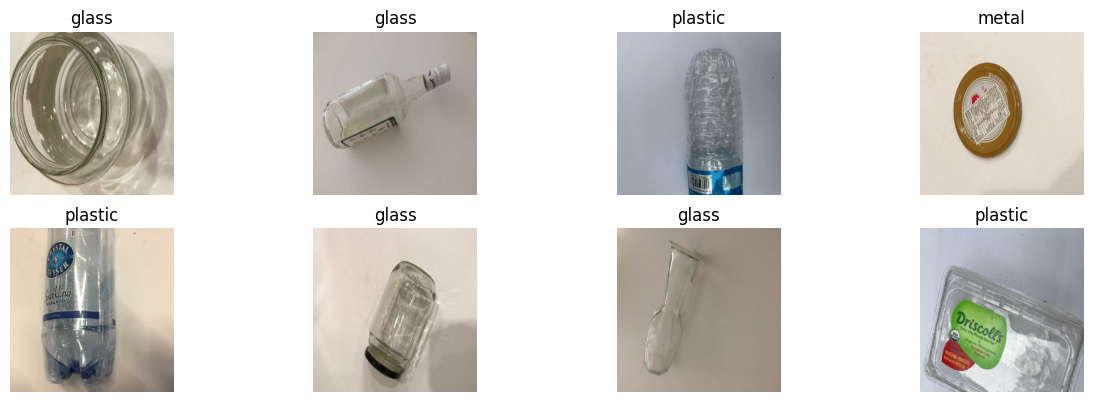

In [ ]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Create model

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(6,activation=tf.nn.softmax))
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 28224)             0         
                                                                 
 dropout_1 (Dropout)         (None, 28224)             0         
                                                                 
 dense_1 (Dense)             (None, 6)                 169350    
                                                                 
Total params: 1108470 (4.23 MB)
Trainable params: 169350 (661.52 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


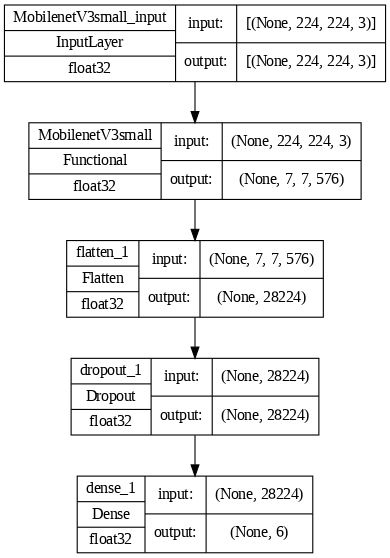

In [ ]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

Fitting model with our Data

In [ ]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

keras_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=10,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/10
65/65 [==============================] - 498s 8s/step - loss: 2.5785 - accuracy: 0.6377 - val_loss: 0.6904 - val_accuracy: 0.8723
Epoch 2/10
65/65 [==============================] - 49s 754ms/step - loss: 0.7909 - accuracy: 0.8850 - val_loss: 0.4655 - val_accuracy: 0.9304
Epoch 3/10
65/65 [==============================] - 39s 598ms/step - loss: 0.3362 - accuracy: 0.9353 - val_loss: 0.3951 - val_accuracy: 0.9420
Epoch 4/10
65/65 [==============================] - 44s 668ms/step - loss: 0.2575 - accuracy: 0.9527 - val_loss: 0.4532 - val_accuracy: 0.9516
Epoch 5/10
65/65 [==============================] - 40s 606ms/step - loss: 0.1721 - accuracy: 0.9696 - val_loss: 0.3282 - val_accuracy: 0.9574
Epoch 6/10
65/65 [==============================] - 47s 721ms/step - loss: 0.1480 - accuracy: 0.9720 - val_loss: 0.6289 - val_accuracy: 0.9304
Epoch 7/10
65/65 [==============================] - 43s 650ms/step - loss: 0.2357 - accuracy: 0.9599 - val_loss: 0.4068 - val_accuracy: 0.9555
E

In [ ]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

17/17 [==============================] - 8s 452ms/step - loss: 0.3282 - accuracy: 0.9574
Test Loss = 0.32821425795555115
Test Accuracy = 0.957446813583374


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  2.578513  0.637681  0.690450      0.872340
1  0.790946  0.885024  0.465503      0.930368
2  0.336214  0.935266  0.395057      0.941973
3  0.257465  0.952657  0.453160      0.951644
4  0.172105  0.969565  0.328214      0.957447
5  0.147975  0.971981  0.628918      0.930368
6  0.235712  0.959903  0.406804      0.955513
7  0.221131  0.965217  0.484386      0.959381
8  0.182181  0.974396  0.360194      0.961315
9  0.164681  0.977778  0.483733      0.957447

Evaluate Our Model

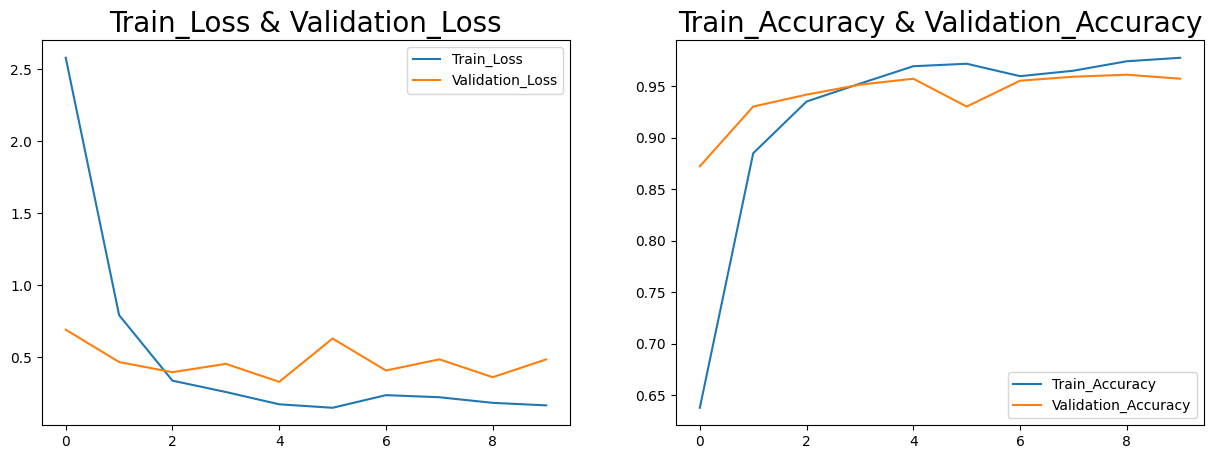

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

17/17 [==============================] - 7s 363ms/step


Actual  Prediction
0         1           1
1         2           2
2         3           3
3         3           3
4         1           1
..      ...         ...
512       3           3
513       2           2
514       0           0
515       4           4
516       1           1

[517 rows x 2 columns]

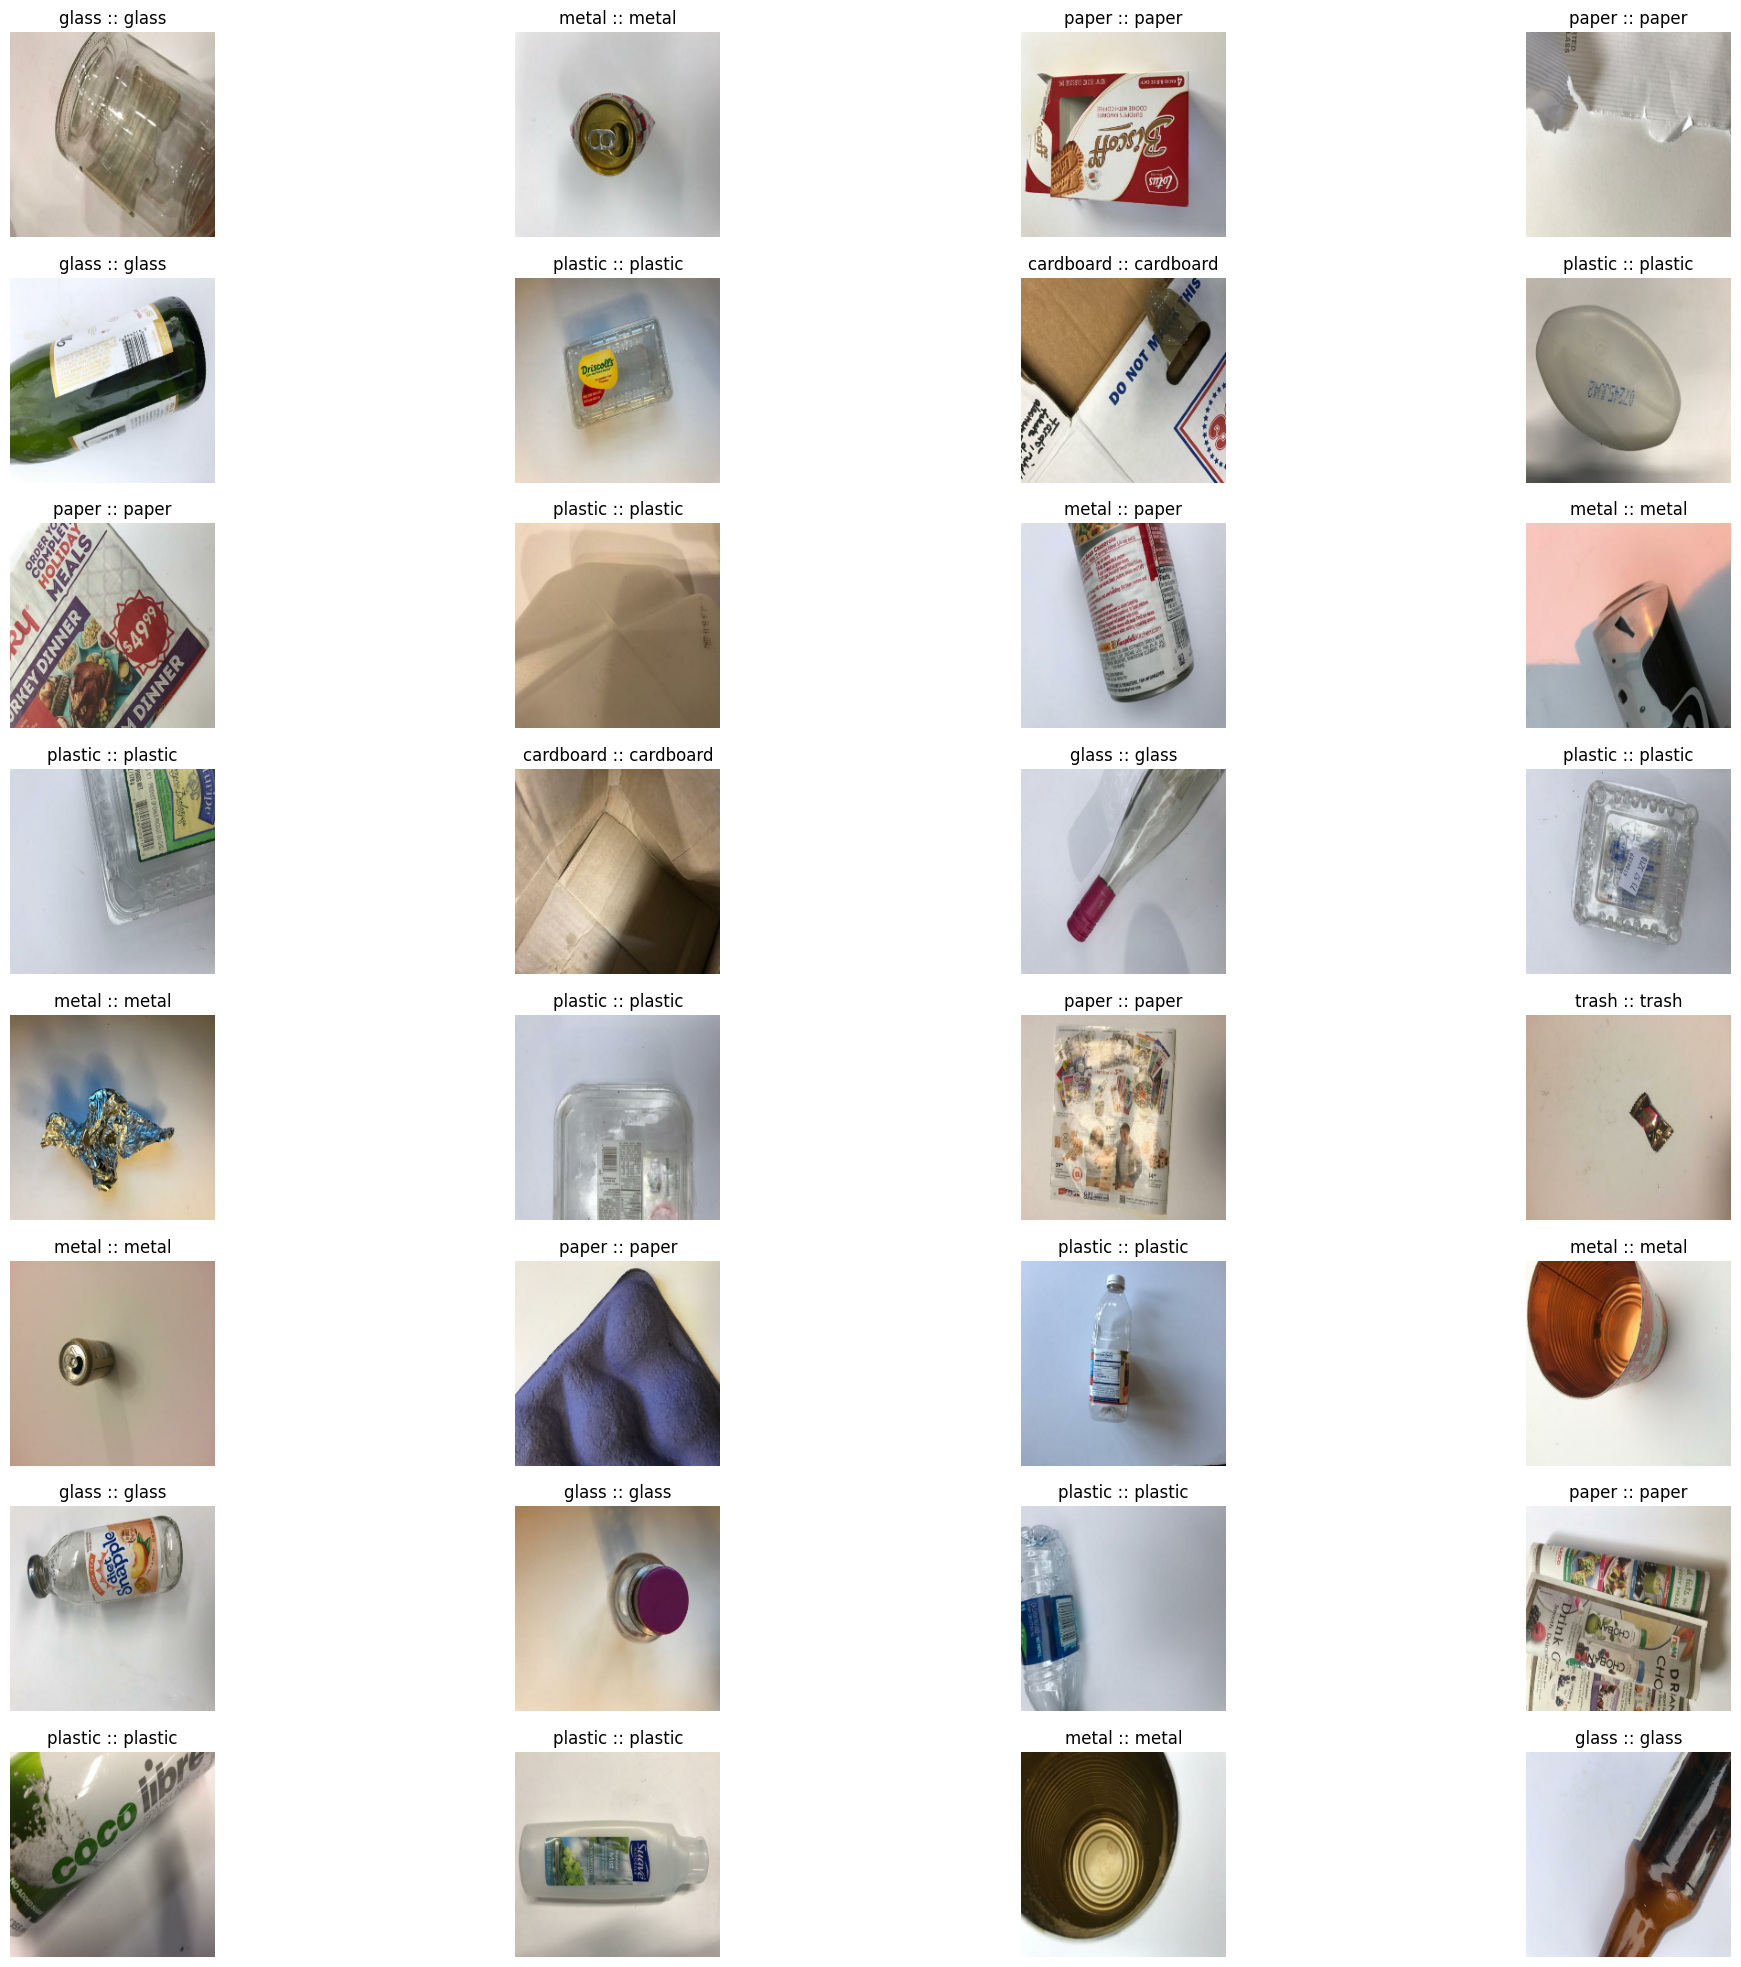

In [ ]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

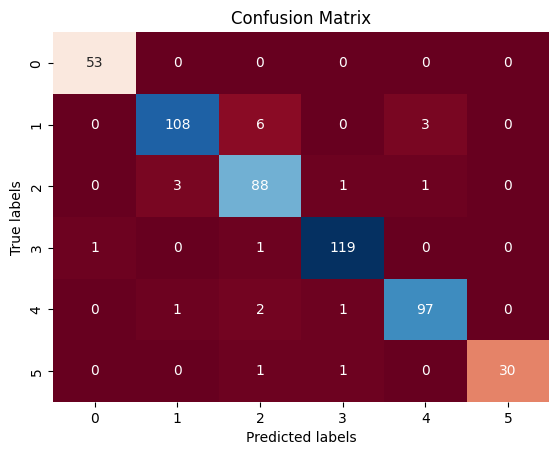

array([[ 53,   0,   0,   0,   0,   0],
       [  0, 108,   6,   0,   3,   0],
       [  0,   3,  88,   1,   1,   0],
       [  1,   0,   1, 119,   0,   0],
       [  0,   1,   2,   1,  97,   0],
       [  0,   0,   1,   1,   0,  30]])

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [ ]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 95.745%


In [ ]:
Model_URL ='https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'
model2 = keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    hub.KerasLayer(Model_URL),
    tf.keras.layers.Dense(120, activation="softmax")])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 25736089 (98.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 25615849 (97.72 MB)
_________________________________________________________________


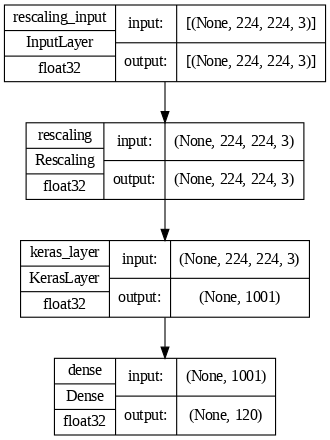

In [ ]:
tf.keras.utils.plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [ ]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

model2.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=model2.fit_generator(train,epochs=10,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/10
65/65 [==============================] - 401s 6s/step - loss: 1.6544 - accuracy: 0.5812 - val_loss: 0.6274 - val_accuracy: 0.7969
Epoch 2/10
65/65 [==============================] - 391s 6s/step - loss: 0.6185 - accuracy: 0.7879 - val_loss: 0.5260 - val_accuracy: 0.8317
Epoch 3/10
65/65 [==============================] - 396s 6s/step - loss: 0.4850 - accuracy: 0.8333 - val_loss: 0.3915 - val_accuracy: 0.8781
Epoch 4/10
65/65 [==============================] - 397s 6s/step - loss: 0.3967 - accuracy: 0.8633 - val_loss: 0.3559 - val_accuracy: 0.8781
Epoch 5/10
65/65 [==============================] - 395s 6s/step - loss: 0.3446 - accuracy: 0.8826 - val_loss: 0.2983 - val_accuracy: 0.8975
Epoch 6/10
65/65 [==============================] - 394s 6s/step - loss: 0.2988 - accuracy: 0.8995 - val_loss: 0.2603 - val_accuracy: 0.9207
Epoch 7/10
65/65 [==============================] - 390s 6s/step - loss: 0.2773 - accuracy: 0.9058 - val_loss: 0.2721 - val_accuracy: 0.9014
Epoch 8/10
65

In [ ]:
score, acc = model2.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

17/17 [==============================] - 77s 5s/step - loss: 0.1939 - accuracy: 0.9497
Test Loss = 0.19385755062103271
Test Accuracy = 0.9497098922729492


In [ ]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model2.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

17/17 [==============================] - 78s 5s/step


Actual  Prediction
0         3           3
1         4           4
2         1           1
3         4           4
4         4           4
..      ...         ...
512       3           3
513       1           1
514       2           2
515       0           0
516       1           1

[517 rows x 2 columns]

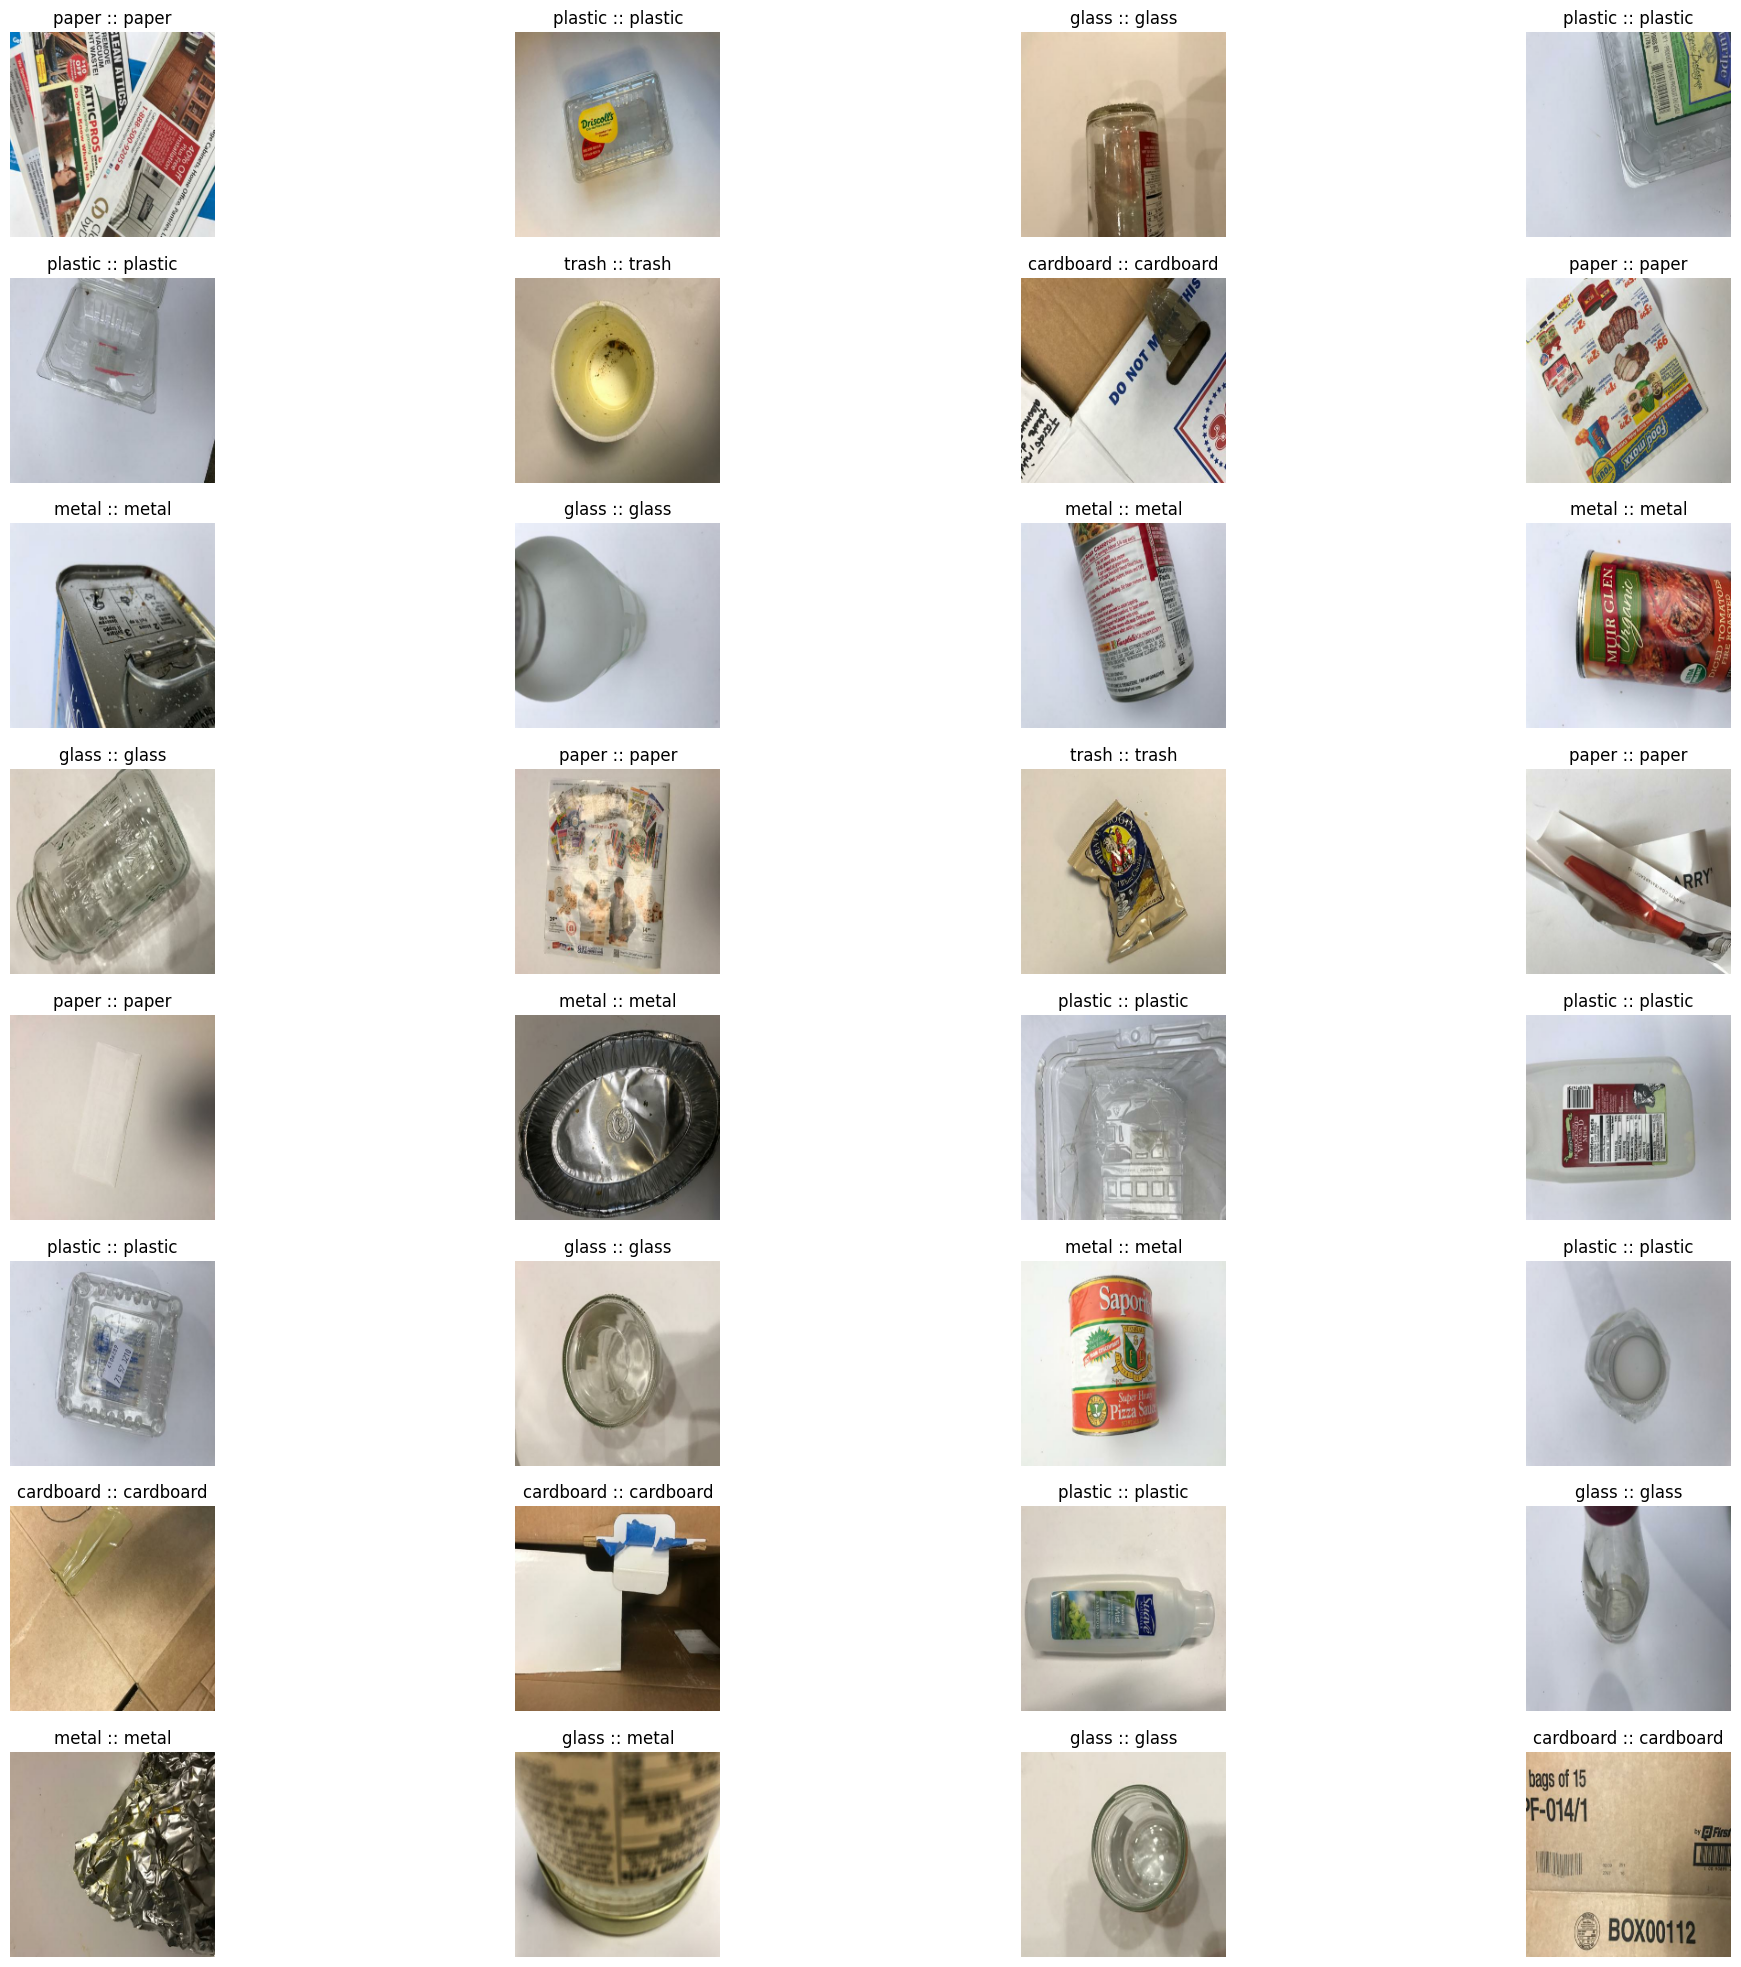

In [ ]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

In [ ]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 94.971%
